# Feature engineering 2: dimensionality and PCA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine

from config import usr, pwd, url, port, db

%matplotlib inline

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

## Data Cleaning
### Missing values
1. Split dataset by state.
2. Sort subset by date.
3. Find columns with missing data.
4. Interpolate missing values using other values in column.
5. If all values in column are missing, then skip that column.

In [7]:
def find_na_columns(df, display_fractions=False):
    na_fractions = (df.isnull().sum()/df.isnull().count())*100
    if display_fractions:
        print(na_fractions)
    return na_fractions[na_fractions != 0]

In [8]:
def apply_interpolation(df):
    states_list = np.unique(df['STATE'])
    
    states_df_list = []
    for state in states_list:
        df_state = df.loc[df['STATE'] == state, :].sort_values(by='YEAR').copy()
    
        na_fractions_state = find_na_columns(df_state.loc[df_state['STATE'] == state, :])
        for column in na_fractions_state.index.tolist():
            
            if na_fractions_state[column] != 100.0:
                df_state.loc[df_state['STATE'] == state,
                             column] = df_state.loc[df_state['STATE'] == state,
                                                    column].interpolate()
    
        states_df_list.append(df_state)
        
    df_interpolated = pd.concat(states_df_list)
    df_interpolated.index = np.arange(len(df_interpolated))
    
    return df_interpolated

In [9]:
df_clean = apply_interpolation(df)

### Dataset subset

In [10]:
columns = []
score_columns = [x for x in df_clean.columns if 'SCORE' in x]  # score columns
expenditure_columns = [x for x in df_clean.columns if 'EXPENDITURE' in x]  # expenditure columns
grade_columns = ['GRADES_4_G', 'GRADES_8_G']  # grade columns
columns += score_columns
columns += expenditure_columns
columns += grade_columns

As I continue the analysis, I am only interested in the following columns:

In [11]:
print(columns)

['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_4_G', 'GRADES_8_G']


In [12]:
df_subset = df_clean.loc[:, columns].copy()

In order to accurately compute weighted averages, I am only interested in rows that do not contain null values. Therefore, I will drop all rows with a null value.

In [13]:
df_subset = df_subset.dropna().copy()
df_subset.index = np.arange(len(df_subset))

In [14]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 11 columns):
AVG_MATH_4_SCORE                1051 non-null float64
AVG_MATH_8_SCORE                1051 non-null float64
AVG_READING_4_SCORE             1051 non-null float64
AVG_READING_8_SCORE             1051 non-null float64
TOTAL_EXPENDITURE               1051 non-null float64
INSTRUCTION_EXPENDITURE         1051 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1051 non-null float64
OTHER_EXPENDITURE               1051 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1051 non-null float64
GRADES_4_G                      1051 non-null float64
GRADES_8_G                      1051 non-null float64
dtypes: float64(11)
memory usage: 98.5 KB


### Outliers
Let's see if any of these columns contain outliers and if so correct them using the Tukey method.

In [15]:
def log_transform(df, column_list):
    for column in column_list:
        df[f'log_{column}'] = np.log(df[column])
    return df

In [16]:
thresholds = {
    'tukey': 1.5
}

In [17]:
def apply_tukey(df, column, thresh=1.5):
    q75, q25 = np.percentile(df[column], [75, 25])
    iqr = q75 - q25
    min_value = q25 - thresh*iqr
    max_value = q75 + thresh*iqr
    df[f'tukey_{column}'] = df[column].apply(lambda x: np.min([x, max_value]))
    df[f'tukey_{column}'] = df[f'tukey_{column}'].apply(lambda x: np.max([x, min_value]))
    return df

In [18]:
def correct_outliers(df, column_list):
    for column in column_list:
        # Tukey
        df = apply_tukey(df, column, thresh=thresholds['tukey'])
        
    return df

In [19]:
def stack_dataframe(df, column_list):
    df_stacked = df.loc[:, column_list].stack().copy()
    df_stacked.index = df_stacked.index.droplevel()
    df_stacked = df_stacked.reset_index().copy()
    df_stacked = df_stacked.rename(columns={'index': 'label', 0: 'value'})
    df_stacked = df_stacked.sort_values(by='label')
    df_stacked.index = np.arange(len(df_stacked))
    return df_stacked

In [20]:
def look_for_outliers(df, column_list):
    
    if len(column_list) > 1:
        df_stacked = stack_dataframe(df, column_list)
        sns.catplot(x='label', y='value', data=df_stacked, height=6, aspect=12/6, kind='box')
        plt.show()
    else:
        sns.catplot(y=column_list[0], data=df, height=6, aspect=12/6, kind='box')
        plt.show()

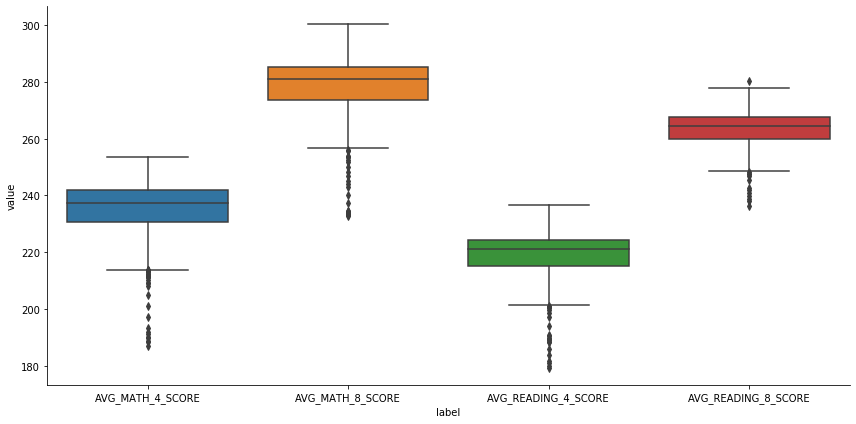

In [21]:
look_for_outliers(df_subset, score_columns)

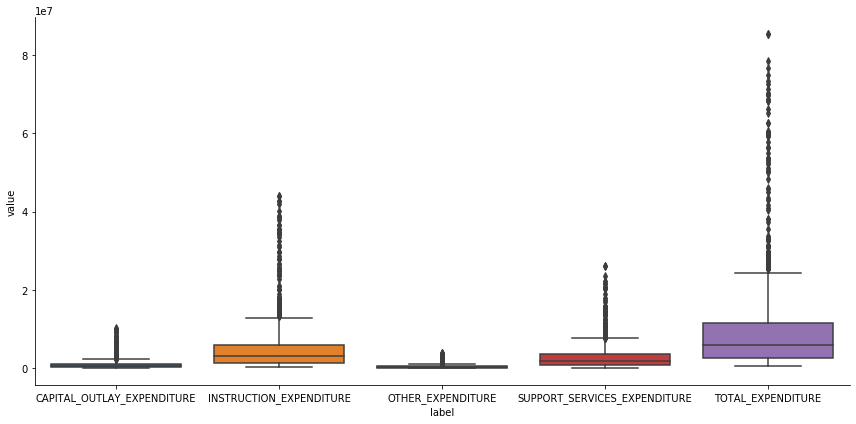

In [22]:
look_for_outliers(df_subset, expenditure_columns)

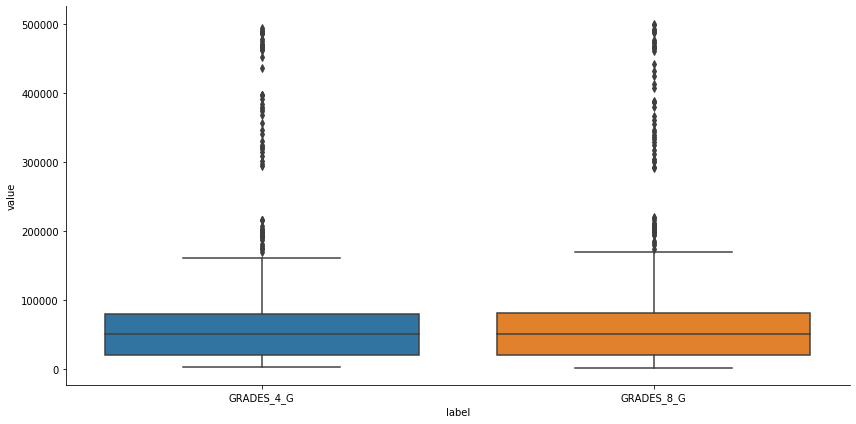

In [23]:
look_for_outliers(df_subset, grade_columns)

**Observations:**

All values contain outliers. The scores are left skewed with small tails. The expenditure types and grades are right skewed with a long tail to large values.

Plan:
1. Log transform expenditure columns.
2. Recheck for outliers.
3. Leave grade columns alone as I will only be interested in ratios between values to compute weighted averages.
4. Correct outliers in scores using Tukey.
5. If there are still outlies in log transformed expenditure columns, correct these using Tukey.

In [24]:
df_subset = log_transform(df_subset, expenditure_columns)

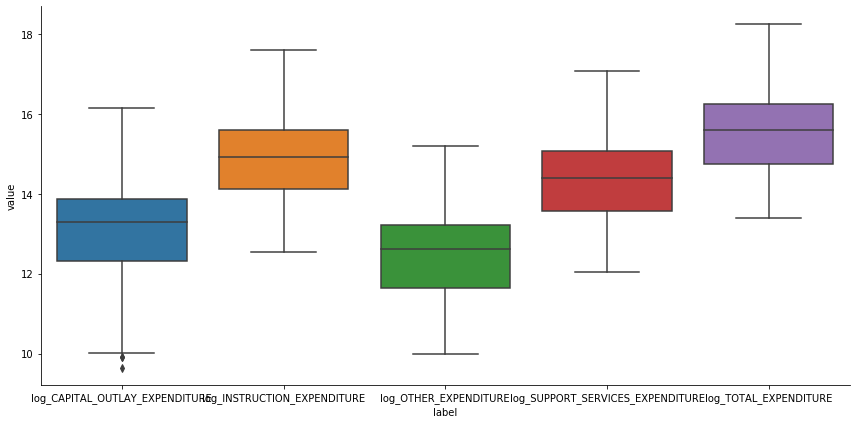

In [25]:
log_expenditure_columns = [f'log_{x}' for x in expenditure_columns]
look_for_outliers(df_subset, log_expenditure_columns)

Correct outliers in scores.

In [26]:
df_subset = correct_outliers(df_subset, score_columns)

In [27]:
corrected_score_columns = [f'tukey_{x}' for x in score_columns]

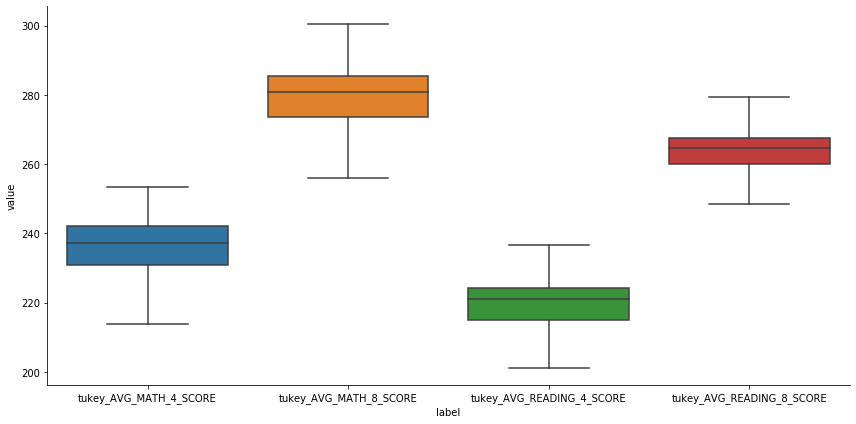

In [28]:
look_for_outliers(df_subset, corrected_score_columns)

In [29]:
columns = []
columns += corrected_score_columns  # score columns
columns += log_expenditure_columns  # expenditure columns
columns += ['GRADES_4_G', 'GRADES_8_G']  # grade columns
df_subset = df_subset.loc[:, columns].copy()

In [30]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 11 columns):
tukey_AVG_MATH_4_SCORE              1051 non-null float64
tukey_AVG_MATH_8_SCORE              1051 non-null float64
tukey_AVG_READING_4_SCORE           1051 non-null float64
tukey_AVG_READING_8_SCORE           1051 non-null float64
log_TOTAL_EXPENDITURE               1051 non-null float64
log_INSTRUCTION_EXPENDITURE         1051 non-null float64
log_SUPPORT_SERVICES_EXPENDITURE    1051 non-null float64
log_OTHER_EXPENDITURE               1051 non-null float64
log_CAPITAL_OUTLAY_EXPENDITURE      1051 non-null float64
GRADES_4_G                          1051 non-null float64
GRADES_8_G                          1051 non-null float64
dtypes: float64(11)
memory usage: 98.5 KB


## Data Exploration
Examine distributions in scores by grade.

In [31]:
def plot_score_distributions(df, prefix):
    score_types = ['math', 'reading']
    grades = [4, 8]
    for score_type in score_types:
        f, axes = plt.subplots(1, 1, figsize=(12, 6))
        for grade in grades:
            sns.distplot(df_subset[f'{prefix}_AVG_{score_type.upper()}_{grade}_SCORE'], kde=False, ax=axes)
        plt.legend([f'{x}th Grade' for x in grades])
        plt.xlabel(f'Average {score_type.title()} Score ({prefix.title()})')
        plt.show()

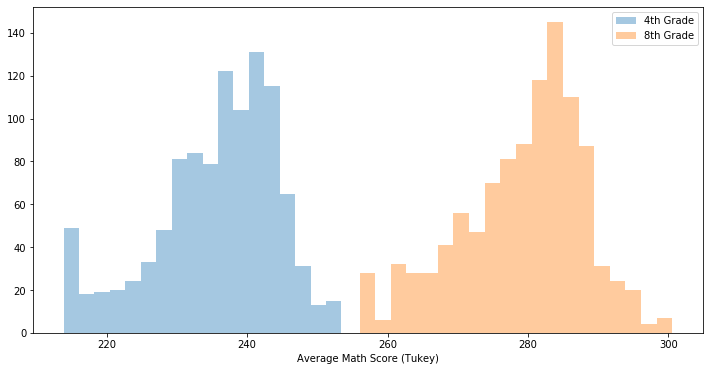

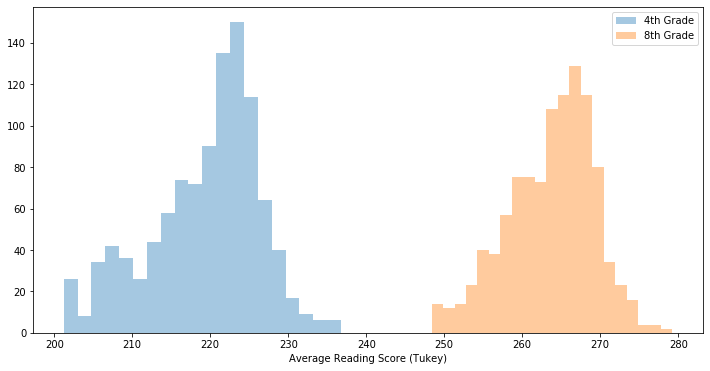

In [32]:
plot_score_distributions(df_subset, 'tukey')

**Observations:**

There is a wide difference in scores between the 4th grade and the 8th grade. Also, each distribution does not appear normal.

### Check for normality

In [33]:
def check_scores_for_normality(df, prefix):
    score_types = ['math', 'reading']
    grades = [4, 8]
    for score_type in score_types:
        for grade in grades:
            column = f'{prefix}_AVG_{score_type.upper()}_{grade}_SCORE'
            normal_stat, pval = normaltest(df[column])
            print(f'There is a {pval} probability that the {column} distribution is normal.')

In [34]:
check_scores_for_normality(df_subset, 'tukey')

There is a 4.2422116678518114e-17 probability that the tukey_AVG_MATH_4_SCORE distribution is normal.
There is a 1.0071991451672394e-11 probability that the tukey_AVG_MATH_8_SCORE distribution is normal.
There is a 1.3670213912968299e-12 probability that the tukey_AVG_READING_4_SCORE distribution is normal.
There is a 1.5911136306650389e-07 probability that the tukey_AVG_READING_8_SCORE distribution is normal.


**Observations:**

The null hypthesis that these distributions are normal can be rejected since all p-values are far below 0.05. Let's apply a Box-Cox transformation to correct for normality.

### Correct for non-normality

In [35]:
def boxcox_transform_scores(df, prefix):
    score_types = ['math', 'reading']
    grades = [4, 8]
    boxcox_score_columns = []
    for score_type in score_types:
        for grade in grades:
            column = f'{prefix}_AVG_{score_type.upper()}_{grade}_SCORE'
            new_column = f'boxcox_AVG_{score_type.upper()}_{grade}_SCORE'
            boxcox_transform, _ = boxcox(df[column])
            df[new_column] = boxcox_transform
    return df

In [36]:
df_subset = boxcox_transform_scores(df_subset, 'tukey')

In [37]:
check_scores_for_normality(df_subset, 'boxcox')

There is a 0.014487737920872105 probability that the boxcox_AVG_MATH_4_SCORE distribution is normal.
There is a 0.2130641078232575 probability that the boxcox_AVG_MATH_8_SCORE distribution is normal.
There is a 0.5680331303644797 probability that the boxcox_AVG_READING_4_SCORE distribution is normal.
There is a 0.5294220324728266 probability that the boxcox_AVG_READING_8_SCORE distribution is normal.


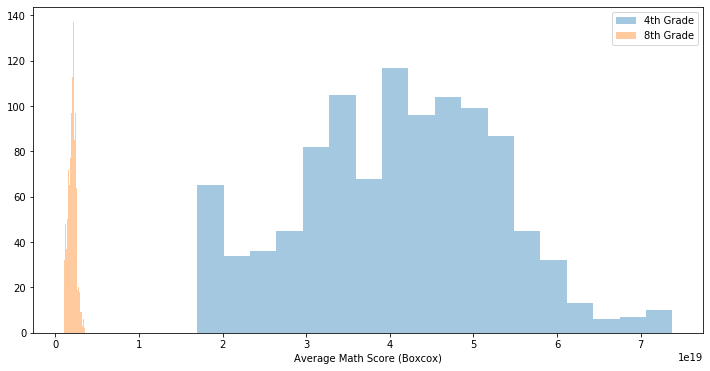

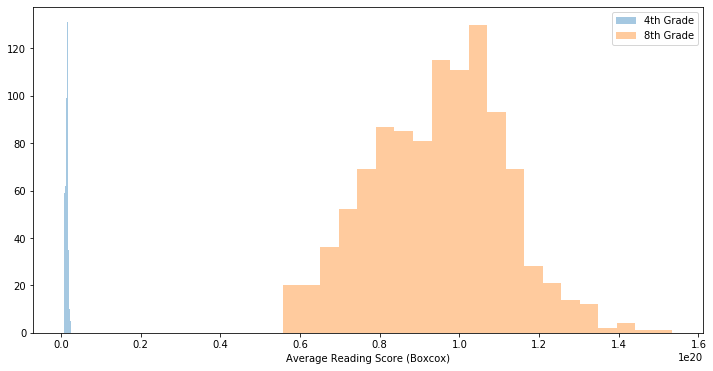

In [38]:
plot_score_distributions(df_subset, 'boxcox')

**Observations:**

The larger p-values indicate that the Box-Cox transformation improved normality for all of the score values. But, the Box-Cox transformed distributions look like they are on very different scales. I will standardize each distribution so that it is on the same scale.

In [39]:
def standardize_scores(df, prefix):
    score_types = ['math', 'reading']
    grades = [4, 8]
    for score_type in score_types:
        for grade in grades:
            mean_score = df[f'{prefix}_AVG_{score_type.upper()}_{grade}_SCORE'].mean()
            std_score = df[f'{prefix}_AVG_{score_type.upper()}_{grade}_SCORE'].std()
            standardized = (df[f'{prefix}_AVG_{score_type.upper()}_{grade}_SCORE'] - mean_score) / std_score
            df[f'standard_AVG_{score_type.upper()}_{grade}_SCORE'] = standardized
    return df

In [40]:
df_standardized = standardize_scores(df_subset, 'boxcox')

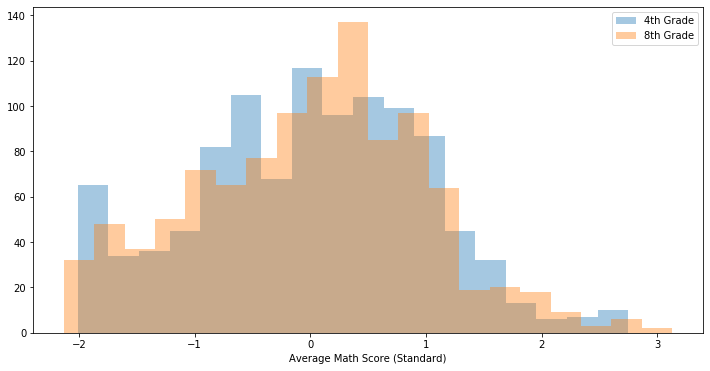

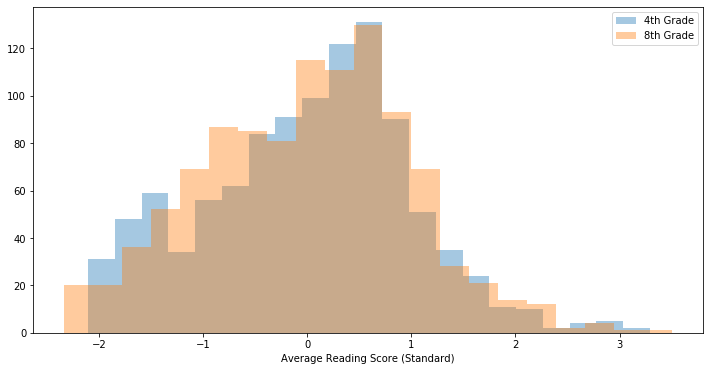

In [41]:
plot_score_distributions(df_standardized, 'standard')

In [42]:
check_scores_for_normality(df_standardized, 'standard')

There is a 0.01448773792087239 probability that the standard_AVG_MATH_4_SCORE distribution is normal.
There is a 0.21306410782325916 probability that the standard_AVG_MATH_8_SCORE distribution is normal.
There is a 0.5680331303644732 probability that the standard_AVG_READING_4_SCORE distribution is normal.
There is a 0.5294220324728217 probability that the standard_AVG_READING_8_SCORE distribution is normal.


### Compute average score
Since all scores have been standardarized, they are all on the same scale. Therefore, to compute the average score I will just do a simple average of the four score columns.

In [43]:
standardized_score_columns = [f'standard_{x}' for x in score_columns]
df_standardized['AVG_STANDARD_SCORE'] = df_standardized.loc[:, standardized_score_columns].mean(axis=1)
df_standardized.loc[:, standardized_score_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
standard_AVG_MATH_4_SCORE,1051.0,-1.081702e-16,1.0,-2.008861,-0.685680,0.051982,0.715333,2.746712
standard_AVG_MATH_8_SCORE,1051.0,-3.650743e-16,1.0,-2.131746,-0.697199,0.103575,0.681415,3.129049
standard_AVG_READING_4_SCORE,1051.0,1.000574e-15,1.0,-2.107460,-0.708075,0.132667,0.654666,3.292714
standard_AVG_READING_8_SCORE,1051.0,3.245105e-16,1.0,-2.341398,-0.730358,0.073141,0.693243,3.507664


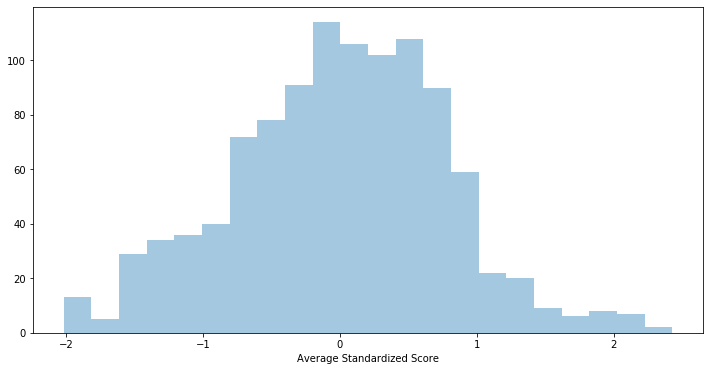

In [44]:
f, axes = plt.subplots(1, 1, figsize=(12, 6))
sns.distplot(df_subset['AVG_STANDARD_SCORE'], kde=False, ax=axes)
plt.xlabel('Average Standardized Score')
plt.show()

In [45]:
normal_stat, pval = normaltest(df_standardized['AVG_STANDARD_SCORE'])
print(f'There is a {pval} probability that this distribution is normal.')

There is a 0.8224591316052938 probability that this distribution is normal.


### Standardize expendiature columns
Before performing PCA, I will standardize all of the expenditure columns and add the additional _AVG\__STANDARD\__SCORE_ column.

In [46]:
df_standard_expenditures = pd.DataFrame(StandardScaler().fit_transform(df_subset.loc[:, 
                                                                                     log_expenditure_columns]), 
                                        columns=log_expenditure_columns)
df_standard_expenditures['AVG_STANDARD_SCORE'] = df_standardized['AVG_STANDARD_SCORE'].values

In [47]:
df_standard_expenditures.describe()

,log_TOTAL_EXPENDITURE,log_INSTRUCTION_EXPENDITURE,log_SUPPORT_SERVICES_EXPENDITURE,log_OTHER_EXPENDITURE,log_CAPITAL_OUTLAY_EXPENDITURE,AVG_STANDARD_SCORE
count,1.051000e+03,1.051000e+03,1.051000e+03,1.051000e+03,1.051000e+03,1.051000e+03
mean,-1.216914e-16,3.752152e-16,-8.416991e-16,3.380317e-17,-1.656356e-16,2.028190e-16
std,1.000476e+00,1.000476e+00,1.000476e+00,1.000476e+00,1.000476e+00,7.786997e-01
min,-2.063382e+00,-2.221267e+00,-2.220649e+00,-2.295888e+00,-2.919238e+00,-2.019888e+00
25%,-7.870343e-01,-7.529442e-01,-7.741245e-01,-7.729947e-01,-6.892989e-01,-5.080228e-01
50%,2.351136e-02,2.199550e-03,3.159070e-02,1.166915e-01,1.310709e-01,3.237817e-02
75%,6.406149e-01,6.454788e-01,6.718942e-01,6.617470e-01,6.017813e-01,5.297765e-01
max,2.533880e+00,2.526569e+00,2.583305e+00,2.485513e+00,2.492658e+00,2.428571e+00


### Correlations
Let's compare the correlations between the average score and expenditure columns.

1. Define column subset
2. Standardize all values between 0 and 1, with a standard deviation of 1.
3. Use Pandas .corr() function to compute correlation coefficients.

In [48]:
df_standard_expenditures.corr()

,log_TOTAL_EXPENDITURE,log_INSTRUCTION_EXPENDITURE,log_SUPPORT_SERVICES_EXPENDITURE,log_OTHER_EXPENDITURE,log_CAPITAL_OUTLAY_EXPENDITURE,AVG_STANDARD_SCORE
log_TOTAL_EXPENDITURE,1.000000,0.997312,0.995206,0.960810,0.919751,0.184190
log_INSTRUCTION_EXPENDITURE,0.997312,1.000000,0.991116,0.957113,0.900628,0.201778
log_SUPPORT_SERVICES_EXPENDITURE,0.995206,0.991116,1.000000,0.954676,0.903974,0.169552
log_OTHER_EXPENDITURE,0.960810,0.957113,0.954676,1.000000,0.892637,0.090708
log_CAPITAL_OUTLAY_EXPENDITURE,0.919751,0.900628,0.903974,0.892637,1.000000,0.068304
AVG_STANDARD_SCORE,0.184190,0.201778,0.169552,0.090708,0.068304,1.000000


In [49]:
df_standard_expenditures.corr()['AVG_STANDARD_SCORE']

log_TOTAL_EXPENDITURE               0.184190
log_INSTRUCTION_EXPENDITURE         0.201778
log_SUPPORT_SERVICES_EXPENDITURE    0.169552
log_OTHER_EXPENDITURE               0.090708
log_CAPITAL_OUTLAY_EXPENDITURE      0.068304
AVG_STANDARD_SCORE                  1.000000
Name: AVG_STANDARD_SCORE, dtype: float64

**Observations:** 

Instruction expenditure has the highest correlation with weighted averaged scores, 0.21.

## PCA
Calculate PCA for the expenditure variables and compare with the overall weighted average.

1. Compute covariance matrix.
2. Compute eigenvalues and eigenvectors.
3. Plot eigenvalues.
4. Print eigenvectors.
5. Choose number of components to use when performing PCA.
6. Compute PCA.
7. Print variance explained ratios.

### Calculate covariance matrix.

In [50]:
X = StandardScaler().fit_transform(df_standard_expenditures.loc[:, log_expenditure_columns])
Xt = X.T
Cx = np.cov(Xt)

print(f'Covariance matrix:\n {Cx}')

Covariance matrix:
 [[1.00095238 0.99826157 0.99615367 0.96172458 0.92062731]
 [0.99826157 1.00095238 0.99205996 0.95802474 0.90148602]
 [0.99615367 0.99205996 1.00095238 0.95558475 0.90483459]
 [0.96172458 0.95802474 0.95558475 1.00095238 0.8934869 ]
 [0.92062731 0.90148602 0.90483459 0.8934869  1.00095238]]


Compute eigen values and eigen vectors.

In [51]:
eigen_values, eigen_vectors = np.linalg.eig(Cx)

In [52]:
print(eigen_vectors)

[[-0.45505594 -0.15498715  0.25062941 -0.82738096 -0.1467267 ]
 [-0.45260655 -0.26931345  0.27758538  0.49561502 -0.63239994]
 [-0.45248057 -0.23988766  0.30980388  0.25284257  0.76013645]
 [-0.44491111 -0.19365841 -0.87391143  0.01157502  0.02636973]
 [-0.43056573  0.89911044  0.02077569  0.07578356 -0.00622892]]


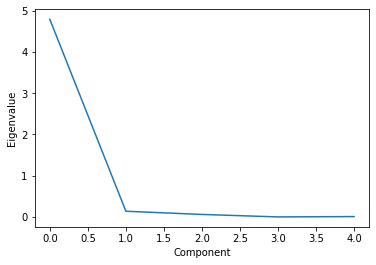

In [53]:
plt.plot(eigen_values)
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.show()

In [54]:
print(f'The eigen values are:\n {eigen_values}')

The eigen values are:
 [4.79572194e+00 1.38369106e-01 6.08378889e-02 7.79633459e-04
 9.05333595e-03]


### PCA - Scikit-Learn
Calculate principle components using Scikit-Learn.

In [55]:
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)

In [56]:
sklearn_pca.explained_variance_ratio_

array([0.95823179, 0.02764749])

In [57]:
print(f'The variance explained ratio of the first component is {sklearn_pca.explained_variance_ratio_[0]:0.3f}.')

The variance explained ratio of the first component is 0.958.


In [58]:
df_standard_expenditures['first_component'] = Y_sklearn[:, 0]

In [59]:
df_standard_expenditures.corr()

,log_TOTAL_EXPENDITURE,log_INSTRUCTION_EXPENDITURE,log_SUPPORT_SERVICES_EXPENDITURE,log_OTHER_EXPENDITURE,log_CAPITAL_OUTLAY_EXPENDITURE,AVG_STANDARD_SCORE,first_component
log_TOTAL_EXPENDITURE,1.000000,0.997312,0.995206,0.960810,0.919751,0.184190,0.996059
log_INSTRUCTION_EXPENDITURE,0.997312,1.000000,0.991116,0.957113,0.900628,0.201778,0.990698
log_SUPPORT_SERVICES_EXPENDITURE,0.995206,0.991116,1.000000,0.954676,0.903974,0.169552,0.990422
log_OTHER_EXPENDITURE,0.960810,0.957113,0.954676,1.000000,0.892637,0.090708,0.973853
log_CAPITAL_OUTLAY_EXPENDITURE,0.919751,0.900628,0.903974,0.892637,1.000000,0.068304,0.942453
AVG_STANDARD_SCORE,0.184190,0.201778,0.169552,0.090708,0.068304,1.000000,0.146938
first_component,0.996059,0.990698,0.990422,0.973853,0.942453,0.146938,1.000000


In [60]:
df_standard_expenditures.corr()['AVG_STANDARD_SCORE']

log_TOTAL_EXPENDITURE               0.184190
log_INSTRUCTION_EXPENDITURE         0.201778
log_SUPPORT_SERVICES_EXPENDITURE    0.169552
log_OTHER_EXPENDITURE               0.090708
log_CAPITAL_OUTLAY_EXPENDITURE      0.068304
AVG_STANDARD_SCORE                  1.000000
first_component                     0.146938
Name: AVG_STANDARD_SCORE, dtype: float64

**Observations:**

The highest correlation with _AVG\__STANDARD\__SCORE_ is _log\__INSTRUCTION\__EXPENDITURE_ and not the _first\__component_. Therefore, I would keep _log\__INSTRUCTION\__EXPENDITURE_ and _AVG\__STANDARD\__SCORE_ as good variables for the model.  Since all of the expenditure variables are highly correlated, it would not be a good idea to include all of them in the model.

### PCA - By Hand

In [61]:
P = eigen_vectors[:, 0]
Y = P.T.dot(Xt)

### Compare PCA Methods

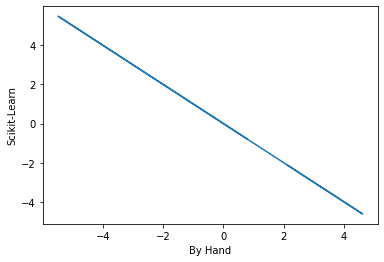

In [62]:
plt.plot(Y, Y_sklearn[:, 0])
plt.xlabel('By Hand')
plt.ylabel('Scikit-Learn')
plt.show()